# Importing packages 

In [3]:
# Data wrangling
import pandas as pd 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

# Date wrangling
import datetime

# Math operations
import numpy as np

# Random sampling
import random

# # Keras API 
# from tensorflow import keras

# # Deep learning 
# from keras.models import Input, Model, Sequential
# from keras.layers import Dense, Dropout, LSTM, Concatenate, SimpleRNN, Masking, Flatten
# from keras import losses
# from keras.callbacks import EarlyStopping
# from keras.initializers import RandomNormal

# Custom functions

In [4]:
# Number of lags (hours back) to use for models
lag = 48

# Steps ahead to forecast 
n_ahead = 1

# Share of obs in testing 
test_share = 0.1


def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

# Reading the data 

In [28]:
d = pd.read_csv('./data/jena_climate_2009_2016/jena_climate_2009_2016.csv/')

print(f'Shape of data: {d.shape}')

Shape of data: (420551, 15)


In [29]:
d['Date Time'] = [datetime.datetime.strptime(x, "%d.%m.%Y %H:%M:%S") for x in d['Date Time']]

In [31]:
cols = ['T (degC)', 'p (mbar)', 'rh (%)', 'wv (m/s)']
d[cols]

,T (degC),p (mbar),rh (%),wv (m/s)
0,-8.02,996.52,93.30,1.03
1,-8.41,996.57,93.40,0.72
2,-8.51,996.53,93.90,0.19
3,-8.31,996.51,94.20,0.34
4,-8.27,996.51,94.10,0.32
...,...,...,...,...
420546,-4.05,1000.07,73.10,0.67
420547,-3.35,999.93,69.71,1.14
420548,-3.16,999.82,67.91,1.08
420549,-4.23,999.81,71.80,1.49


In [26]:
d.resample('H', on='Date Time').mean()
d.fillna(d.mean())
for col in ['wv (m/s)', 'max. wv (m/s)']:
    d[col] = d[col].replace(-9999.00, 0)
cols = list(d)[1:d.shape[1]]
cols

['p (mbar)',
 'T (degC)',
 'Tpot (K)',
 'Tdew (degC)',
 'rh (%)',
 'VPmax (mbar)',
 'VPact (mbar)',
 'VPdef (mbar)',
 'sh (g/kg)',
 'H2OC (mmol/mol)',
 'rho (g/m**3)',
 'wv (m/s)',
 'max. wv (m/s)',
 'wd (deg)']

In [27]:
# Select features (columns) to be involved intro training and predictions
cols = list(d)[1:d.shape[1]]

features = d[cols]
features = (features - features.mean(axis=0)) / features.std(axis=0)
features.values

array([[ 0.87422872, -2.07401044, -2.12743892, ..., -0.71332845,
        -0.76141346, -0.25892132],
       [ 0.88021067, -2.12031022, -2.17329715, ..., -0.91432249,
        -0.86822908, -0.445812  ],
       [ 0.87542511, -2.13218196, -2.18505567, ..., -1.25795745,
        -1.23994743, -0.03626762],
       ...,
       [ 1.26903732, -1.49704388, -1.58537113, ..., -0.68091006,
        -0.65459784,  0.4667221 ],
       [ 1.26784093, -1.6240715 , -1.7111873 , ..., -0.41507924,
        -0.58623585,  0.58900859],
       [ 1.26903732, -1.69411476, -1.77938672, ..., -0.58365488,
        -0.67168834,  0.11716732]])

In [4]:
d.sample(5)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
322222,15.02.2015 01:50:00,986.10,-2.58,271.67,-3.79,91.30,5.05,4.61,0.44,2.91,4.68,1267.31,0.59,1.32,191.10
337213,30.05.2015 04:20:00,983.90,7.52,281.99,5.94,89.70,10.39,9.32,1.07,5.91,9.47,1216.78,2.41,4.08,255.10
243616,18.08.2013 19:20:00,988.50,19.00,293.13,12.77,67.14,22.01,14.78,7.23,9.35,14.95,1171.99,2.21,3.12,212.90
79659,07.07.2010 05:00:00,996.47,9.28,282.73,8.16,92.70,11.71,10.86,0.86,6.81,10.90,1223.99,1.11,1.60,180.00
193039,01.09.2012 13:40:00,998.07,18.01,291.33,9.55,57.67,20.69,11.93,8.76,7.47,11.95,1188.72,3.65,6.14,44.26


In [5]:
# Types of columns
d.dtypes

Date Time           object
p (mbar)           float64
T (degC)           float64
Tpot (K)           float64
Tdew (degC)        float64
rh (%)             float64
VPmax (mbar)       float64
VPact (mbar)       float64
VPdef (mbar)       float64
sh (g/kg)          float64
H2OC (mmol/mol)    float64
rho (g/m**3)       float64
wv (m/s)           float64
max. wv (m/s)      float64
wd (deg)           float64
dtype: object

In [6]:
d['Date Time']

0         01.01.2009 00:10:00
1         01.01.2009 00:20:00
2         01.01.2009 00:30:00
3         01.01.2009 00:40:00
4         01.01.2009 00:50:00
                 ...         
420546    31.12.2016 23:20:00
420547    31.12.2016 23:30:00
420548    31.12.2016 23:40:00
420549    31.12.2016 23:50:00
420550    01.01.2017 00:00:00
Name: Date Time, Length: 420551, dtype: object

In [7]:
# Converting the dt column to datetime object 
d['Date Time'] = [datetime.datetime.strptime(x, "%d.%m.%Y %H:%M:%S") for x in d['Date Time']]

# Sorting by the date 
d.sort_values('Date Time', inplace=True)

In [8]:
# Listing the min and the max dates 
print(f"First date {min(d['Date Time'])}")
print(f"Most recent date {max(d['Date Time'])}")

First date 2009-01-01 00:10:00
Most recent date 2017-01-01 00:00:00


# Data cleaning 

In [9]:
d = d[d['max. wv (m/s)'] > -9000]

In [10]:
print(f"Total unique dates in the dataset: {len(set(d['Date Time']))}")

Total unique dates in the dataset: 420204


In [11]:
print(f"Number of rows in the dataset: {d.shape[0]}")

Number of rows in the dataset: 420531


In [12]:
# Date Time           object
# p (mbar)           float64
# T (degC)           float64
# Tpot (K)           float64
# Tdew (degC)        float64
# rh (%)             float64
# VPmax (mbar)       float64
# VPact (mbar)       float64
# VPdef (mbar)       float64
# sh (g/kg)          float64
# H2OC (mmol/mol)    float64
# rho (g/m**3)       float64
# wv (m/s)           float64
# max. wv (m/s)      float64
# wd (deg)           float64


# Features used in models
features = ['p (mbar)', 'T (degC)', 'wv (m/s)']

# Aggregating to hourly level
d = d.groupby('Date Time', as_index=False)[features].mean()

# Creating the data column
d['date'] = [x.date() for x in d['Date Time']]

# Explanatory data analysis 

## Descriptive statistics

In [13]:
d[features].describe()

,p (mbar),T (degC),wv (m/s)
count,420204.000000,420204.000000,420204.000000
mean,989.214110,9.442007,2.129249
std,8.361084,8.421120,1.540066
min,913.600000,-23.010000,0.000000
25%,984.200000,3.360000,0.990000
50%,989.580000,9.400000,1.760000
75%,994.730000,15.460000,2.860000
max,1015.350000,37.280000,14.630000


# Feature engineering

In [19]:
# Extracting the hour of day
d['hour'] = [x.hour for x in d['Date Time']]

# Extracting the month of the year 
d['month'] = [x.month for x in d['Date Time']]

In [22]:
# Creating the cyclical daily feature 
d['day_cos'] = [np.cos(x * (2 * np.pi / 24)) for x in d['hour']]
d['day_sin'] = [np.sin(x * (2 * np.pi / 24)) for x in d['hour']]

In [23]:
dsin = d[['Date Time', 'T (degC)', 'hour', 'day_sin', 'day_cos']].head(25).copy()
dsin['day_sin'] = [round(x, 3) for x in dsin['day_sin']]
dsin['day_cos'] = [round(x, 3) for x in dsin['day_cos']]

dsin

,Date Time,T (degC),hour,day_sin,day_cos
0,2009-01-01 00:10:00,-8.02,0,0.000,1.000
1,2009-01-01 00:20:00,-8.41,0,0.000,1.000
2,2009-01-01 00:30:00,-8.51,0,0.000,1.000
3,2009-01-01 00:40:00,-8.31,0,0.000,1.000
4,2009-01-01 00:50:00,-8.27,0,0.000,1.000
5,2009-01-01 01:00:00,-8.05,1,0.259,0.966
6,2009-01-01 01:10:00,-7.62,1,0.259,0.966
7,2009-01-01 01:20:00,-7.62,1,0.259,0.966
8,2009-01-01 01:30:00,-7.91,1,0.259,0.966
9,2009-01-01 01:40:00,-8.43,1,0.259,0.966


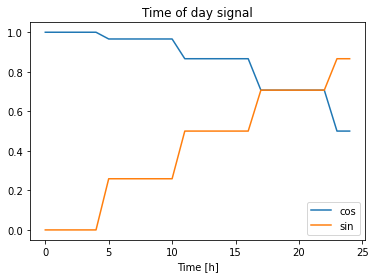

In [24]:
# Ploting the first 25 hours 
plt.plot(np.array(d['day_cos'])[:25], label='cos')
plt.plot(np.array(d['day_sin'])[:25], label='sin')
plt.xlabel('Time [h]')
plt.title('Time of day signal')
plt.legend()
plt.show()

In [25]:
# Extracting the timestamp from the datetime object 
d['timestamp'] = [x.timestamp() for x in d['Date Time']]

# Seconds in day 
s = 24 * 60 * 60 

# Seconds in year 
year = (365.25) * s

d['month_cos'] = [np.cos((x) * (2 * np.pi / year)) for x in d['timestamp']]
d['month_sin'] = [np.sin((x) * (2 * np.pi / year)) for x in d['timestamp']]

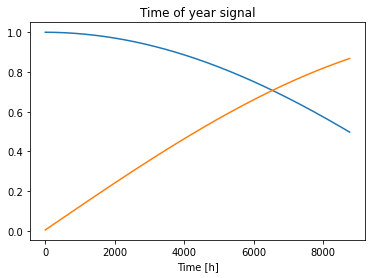

In [26]:
# Ploting the first year
plt.plot(np.array(d['month_cos'])[:24 * 365])
plt.plot(np.array(d['month_sin'])[:24 * 365])
plt.xlabel('Time [h]')
plt.title('Time of year signal')
plt.show()

# Single step forecast

## Hyper parameters

In [33]:
# Number of lags (hours back) to use for models
lag = 48

# Steps ahead to forecast 
n_ahead = 1

# Share of obs in testing 
test_share = 0.1

# Epochs for training
epochs = 20

# Batch size 
batch_size = 512

# Learning rate
lr = 0.001

# Number of neurons in LSTM layer
n_layer = 10

# The features used in the modeling 
features_final = ['T (degC)', 'day_cos', 'day_sin', 'month_sin', 'month_cos', 'p (mbar)', 'wv (m/s)']

## Creating the matrices for training

In [34]:
d[features_final].head(10)

,T (degC),day_cos,day_sin,month_sin,month_cos,p (mbar),wv (m/s)
0,-8.02,1.000000,0.000000,0.004420,0.999990,996.52,1.03
1,-8.41,1.000000,0.000000,0.004540,0.999990,996.57,0.72
2,-8.51,1.000000,0.000000,0.004659,0.999989,996.53,0.19
3,-8.31,1.000000,0.000000,0.004778,0.999989,996.51,0.34
4,-8.27,1.000000,0.000000,0.004898,0.999988,996.51,0.32
5,-8.05,0.965926,0.258819,0.005017,0.999987,996.50,0.21
6,-7.62,0.965926,0.258819,0.005137,0.999987,996.50,0.18
7,-7.62,0.965926,0.258819,0.005256,0.999986,996.50,0.19
8,-7.91,0.965926,0.258819,0.005376,0.999986,996.50,0.28
9,-8.43,0.965926,0.258819,0.005495,0.999985,996.53,0.59


In [39]:
# Subseting only the needed columns 
ts = d[features_final]

nrows = ts.shape[0]

# Spliting into train and test sets
train = ts[0:int(nrows * (1 - test_share))]
test = ts[int(nrows * (1 - test_share)):]

# Scaling the data 
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

# Creating the final scaled frame 
ts_s = pd.concat([train, test])

ts_s

,T (degC),day_cos,day_sin,month_sin,month_cos,p (mbar),wv (m/s)
0,-2.037121,1.414198,0.000055,-0.014563,1.380413,0.897052,-0.722510
1,-2.083330,1.414198,0.000055,-0.014393,1.380412,0.903005,-0.921961
2,-2.095178,1.414198,0.000055,-0.014223,1.380411,0.898243,-1.262958
3,-2.071482,1.414198,0.000055,-0.014054,1.380411,0.895861,-1.166449
4,-2.066742,1.414198,0.000055,-0.013884,1.380410,0.895861,-1.179317
...,...,...,...,...,...,...,...
420199,-1.566739,1.366011,-0.365980,-0.015411,1.380416,1.319744,-0.954130
420200,-1.483800,1.366011,-0.365980,-0.015241,1.380416,1.303074,-0.651737
420201,-1.461288,1.366011,-0.365980,-0.015071,1.380415,1.289977,-0.690340
420202,-1.588066,1.366011,-0.365980,-0.014902,1.380414,1.288786,-0.426550


In [36]:
X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)

n_ft = X.shape[2]

In [37]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

In [38]:
print(f"Shape of training data: {Xtrain.shape}")
print(f"Shape of the target data: {Ytrain.shape}")

print(f"Shape of validation data: {Xval.shape}")
print(f"Shape of the validation target data: {Yval.shape}")

Shape of training data: (378139, 48, 7)
Shape of the target data: (378139, 1)
Shape of validation data: (42016, 48, 7)
Shape of the validation target data: (42016, 1)


# Defining the model 

In [32]:
class NNMultistepModel():
    
    def __init__(
        self, 
        X, 
        Y, 
        n_outputs,
        n_lag,
        n_ft,
        n_layer,
        batch,
        epochs, 
        lr,
        Xval=None,
        Yval=None,
        mask_value=-999.0,
        min_delta=0.001,
        patience=5
    ):
        lstm_input = Input(shape=(n_lag, n_ft))

        # Series signal 
        lstm_layer = LSTM(n_layer, activation='relu')(lstm_input)

        x = Dense(n_outputs)(lstm_layer)
        
        self.model = Model(inputs=lstm_input, outputs=x)
        self.batch = batch 
        self.epochs = epochs
        self.n_layer=n_layer
        self.lr = lr 
        self.Xval = Xval
        self.Yval = Yval
        self.X = X
        self.Y = Y
        self.mask_value = mask_value
        self.min_delta = min_delta
        self.patience = patience

    def trainCallback(self):
        return EarlyStopping(monitor='loss', patience=self.patience, min_delta=self.min_delta)

    def train(self):
        # Getting the untrained model 
        empty_model = self.model
        
        # Initiating the optimizer
        optimizer = keras.optimizers.Adam(learning_rate=self.lr)

        # Compiling the model
        empty_model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)

        if (self.Xval is not None) & (self.Yval is not None):
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch, 
                validation_data=(self.Xval, self.Yval), 
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        else:
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch,
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        
        # Saving to original model attribute in the class
        self.model = empty_model
        
        # Returning the training history
        return history
    
    def predict(self, X):
        return self.model.predict(X)

In [33]:
model = NNMultistepModel(
    X=Xtrain,
    Y=Ytrain,
    n_outputs=n_ahead,
    n_lag=lag,
    n_ft=n_ft,
    n_layer=n_layer,
    batch=batch_size,
    epochs=epochs, 
    lr=lr,
    Xval=Xval,
    Yval=Yval,
)

In [34]:
model.model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 7)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 10)                720       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 731
Trainable params: 731
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model.train()

Epoch 1/20
477/477 [==============================] - 10s 21ms/step - loss: 0.2691 - val_loss: 0.1387
Epoch 2/20
477/477 [==============================] - 10s 22ms/step - loss: 0.1213 - val_loss: 0.0986
Epoch 3/20
477/477 [==============================] - 10s 21ms/step - loss: 0.1001 - val_loss: 0.0804
Epoch 4/20
477/477 [==============================] - 10s 21ms/step - loss: 0.0866 - val_loss: 0.0792
Epoch 5/20
477/477 [==============================] - 10s 20ms/step - loss: 0.0779 - val_loss: 0.0668
Epoch 6/20
477/477 [==============================] - 10s 20ms/step - loss: 0.0735 - val_loss: 0.0715
Epoch 7/20
477/477 [==============================] - 9s 20ms/step - loss: 0.0717 - val_loss: 0.0575
Epoch 8/20
477/477 [==============================] - 10s 20ms/step - loss: 0.0675 - val_loss: 0.0666
Epoch 9/20
477/477 [==============================] - 9s 19ms/step - loss: 0.0675 - val_loss: 0.0535
Epoch 10/20
477/477 [==============================] - 9s 18ms/step - loss: 0.0642 -

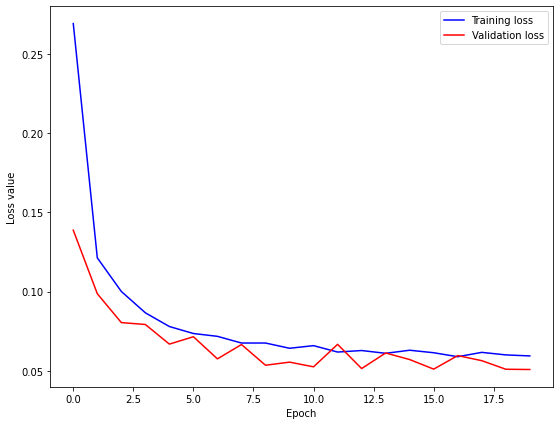

In [36]:
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(loss))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, loss, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [37]:
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model.predict(Xval)]
y = [y[0] for y in Yval]

In [53]:
# Creating the frame to store both predictions
days = d['dt'].values[-len(y):]

frame = pd.concat([
    pd.DataFrame({'day': days, 'temp': y, 'type': 'original'}),
    pd.DataFrame({'day': days, 'temp': yhat, 'type': 'forecast'})
])

# Creating the unscaled values column
frame['temp_absolute'] = [(x * train_std['temp']) + train_mean['temp'] for x in frame['temp']]

# Pivoting
pivoted = frame.pivot_table(index='day', columns='type')
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]
pivoted['res'] = pivoted['temp_absolute_original'] - pivoted['temp_absolute_forecast']
pivoted['res_abs'] = [abs(x) for x in pivoted['res']]

In [54]:
pivoted.tail(10)

,temp_forecast,temp_original,temp_absolute_forecast,temp_absolute_original,res,res_abs
day,,,,,,
2020-11-30 14:00:00,-0.793414,-0.791943,-0.523923,-0.51,0.013923,0.013923
2020-11-30 15:00:00,-0.823321,-0.797228,-0.806867,-0.56,0.246867,0.246867
2020-11-30 16:00:00,-0.825288,-0.798285,-0.825478,-0.57,0.255478,0.255478
2020-11-30 17:00:00,-0.825989,-0.816253,-0.832110,-0.74,0.092110,0.092110
2020-11-30 18:00:00,-0.841069,-0.835279,-0.974783,-0.92,0.054783,0.054783
2020-11-30 19:00:00,-0.861765,-0.836336,-1.170583,-0.93,0.240583,0.240583
2020-11-30 20:00:00,-0.865690,-0.835279,-1.207718,-0.92,0.287718,0.287718
2020-11-30 21:00:00,-0.868307,-0.827880,-1.232481,-0.85,0.382481,0.382481
2020-11-30 22:00:00,-0.869778,-0.827880,-1.246393,-0.85,0.396393,0.396393


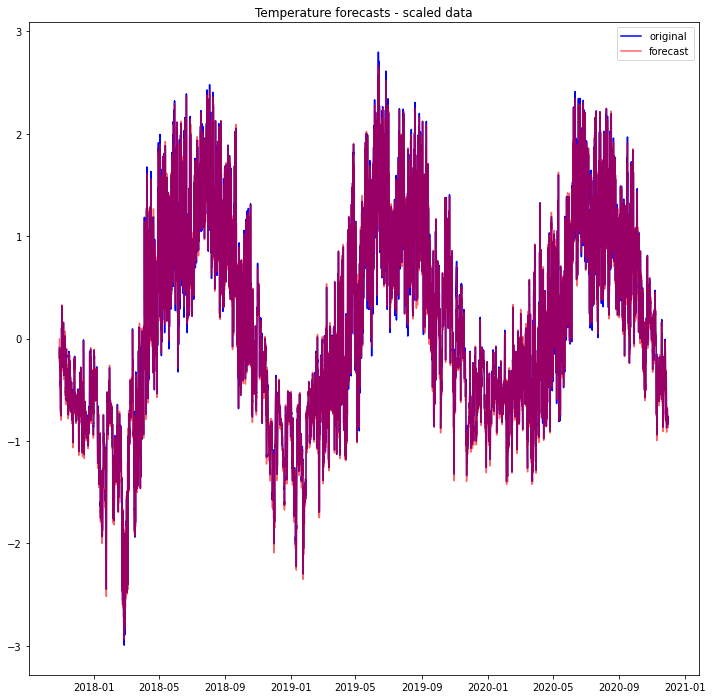

In [67]:
plt.figure(figsize=(12, 12))
plt.plot(pivoted.index, pivoted.temp_original, color='blue', label='original')
plt.plot(pivoted.index, pivoted.temp_forecast, color='red', label='forecast', alpha=0.6)
plt.title('Temperature forecasts - scaled data')
plt.legend()
plt.show()

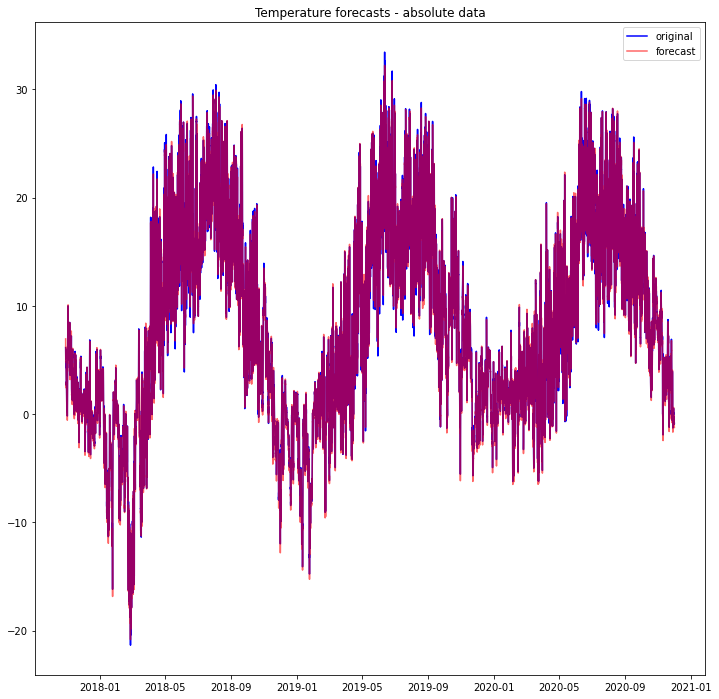

In [73]:
plt.figure(figsize=(12, 12))
plt.plot(pivoted.index, pivoted.temp_absolute_original, color='blue', label='original')
plt.plot(pivoted.index, pivoted.temp_absolute_forecast, color='red', label='forecast', alpha=0.6)
plt.title('Temperature forecasts - absolute data')
plt.legend()
plt.show()

In [43]:
pivoted = frame.pivot_table(index='day', columns='type')
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]
pivoted['res'] = pivoted['temp_absolute_original'] - pivoted['temp_absolute_forecast']
pivoted['res_abs'] = [abs(x) for x in pivoted['res']]

In [50]:
pivoted.tail(10)

,temp_forecast,temp_original,temp_absolute_forecast,temp_absolute_original,res,res_abs
day,,,,,,
2020-11-30 14:00:00,-0.793414,-0.791943,-0.523923,-0.51,0.013923,0.013923
2020-11-30 15:00:00,-0.823321,-0.797228,-0.806867,-0.56,0.246867,0.246867
2020-11-30 16:00:00,-0.825288,-0.798285,-0.825478,-0.57,0.255478,0.255478
2020-11-30 17:00:00,-0.825989,-0.816253,-0.832110,-0.74,0.092110,0.092110
2020-11-30 18:00:00,-0.841069,-0.835279,-0.974783,-0.92,0.054783,0.054783
2020-11-30 19:00:00,-0.861765,-0.836336,-1.170583,-0.93,0.240583,0.240583
2020-11-30 20:00:00,-0.865690,-0.835279,-1.207718,-0.92,0.287718,0.287718
2020-11-30 21:00:00,-0.868307,-0.827880,-1.232481,-0.85,0.382481,0.382481
2020-11-30 22:00:00,-0.869778,-0.827880,-1.246393,-0.85,0.396393,0.396393


In [74]:
print(f"Average absolute mean error: {round(pivoted['res_abs'].sum() / pivoted.shape[0], 2)} C")

Average absolute mean error: 0.48 C


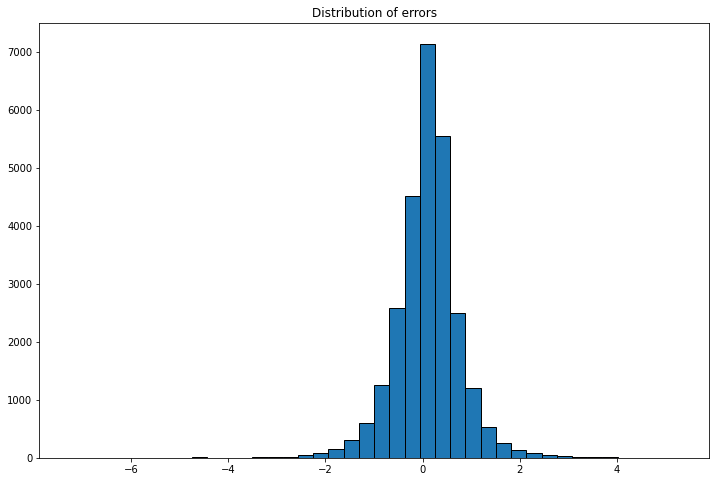

In [75]:
plt.figure(figsize=(12, 8))
plt.hist(pivoted.res, bins=40, edgecolor='black')
plt.title('Distribution of errors')
plt.show()

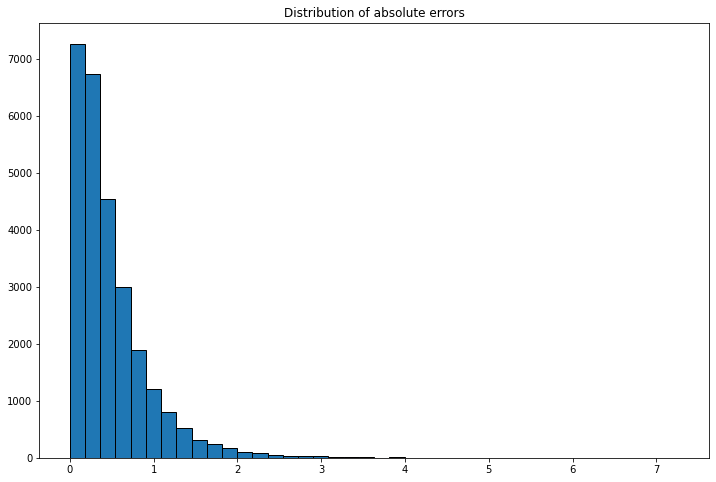

In [76]:
plt.figure(figsize=(12, 8))
plt.hist(pivoted.res_abs, bins=40, edgecolor='black')
plt.title('Distribution of absolute errors')
plt.show()

In [47]:
pivoted.res_abs.describe()

count    27096.000000
mean         0.480791
std          0.467825
min          0.000008
25%          0.168428
50%          0.348462
75%          0.645027
max          7.263866
Name: res_abs, dtype: float64

# Sequence prediction 

In [101]:
# Number of lags (hours back) to use for models
lag = 168

# Steps ahead to forecast 
n_ahead = 24

# Share of obs in testing 
test_share = 0.1

# Epochs for training
epochs = 20

# Batch size 
batch_size = 512

# Learning rate
lr = 0.001

# Number of neurons in LSTM layer
n_layer = 10

In [102]:
X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)

n_ft = X.shape[2]

In [103]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

print(f"Shape of training data: {Xtrain.shape}")
print(f"Shape of the target data: {Ytrain.shape}")

print(f"Shape of validation data: {Xval.shape}")
print(f"Shape of the validation target data: {Yval.shape}")

Shape of training data: (243734, 168, 7)
Shape of the target data: (243734, 24)
Shape of validation data: (27082, 168, 7)
Shape of the validation target data: (27082, 24)


In [104]:
model = NNMultistepModel(
    X=Xtrain,
    Y=Ytrain,
    n_outputs=n_ahead,
    n_lag=lag,
    n_ft=n_ft,
    n_layer=n_layer,
    batch=batch_size,
    epochs=epochs, 
    lr=lr,
    Xval=Xval,
    Yval=Yval,
)

In [105]:
model.model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 168, 7)]          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                720       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                264       
Total params: 984
Trainable params: 984
Non-trainable params: 0
_________________________________________________________________


In [106]:
history = model.train()

Epoch 1/20
477/477 [==============================] - 30s 62ms/step - loss: 0.4952 - val_loss: 0.2761
Epoch 2/20
477/477 [==============================] - 30s 63ms/step - loss: 0.2526 - val_loss: 0.2215
Epoch 3/20
477/477 [==============================] - 27s 56ms/step - loss: 0.2167 - val_loss: 0.2071
Epoch 4/20
477/477 [==============================] - 24s 51ms/step - loss: 0.2070 - val_loss: 0.2002
Epoch 5/20
477/477 [==============================] - 20s 43ms/step - loss: 0.2010 - val_loss: 0.1960
Epoch 6/20
477/477 [==============================] - 19s 41ms/step - loss: 0.1971 - val_loss: 0.1929
Epoch 7/20
477/477 [==============================] - 19s 40ms/step - loss: 0.1943 - val_loss: 0.1903
Epoch 8/20
477/477 [==============================] - 19s 40ms/step - loss: 0.1921 - val_loss: 0.1884
Epoch 9/20
477/477 [==============================] - 19s 40ms/step - loss: 0.1902 - val_loss: 0.1868
Epoch 10/20
477/477 [==============================] - 19s 40ms/step - loss: 0.188

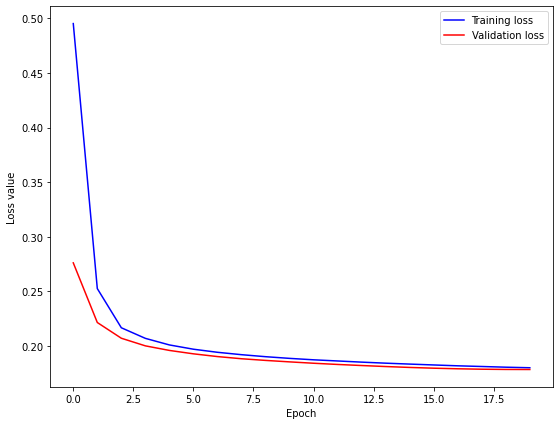

In [107]:
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(loss))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, loss, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [108]:
# Forecasting on all the samples in the validation set 
forecast = model.predict(Xval)

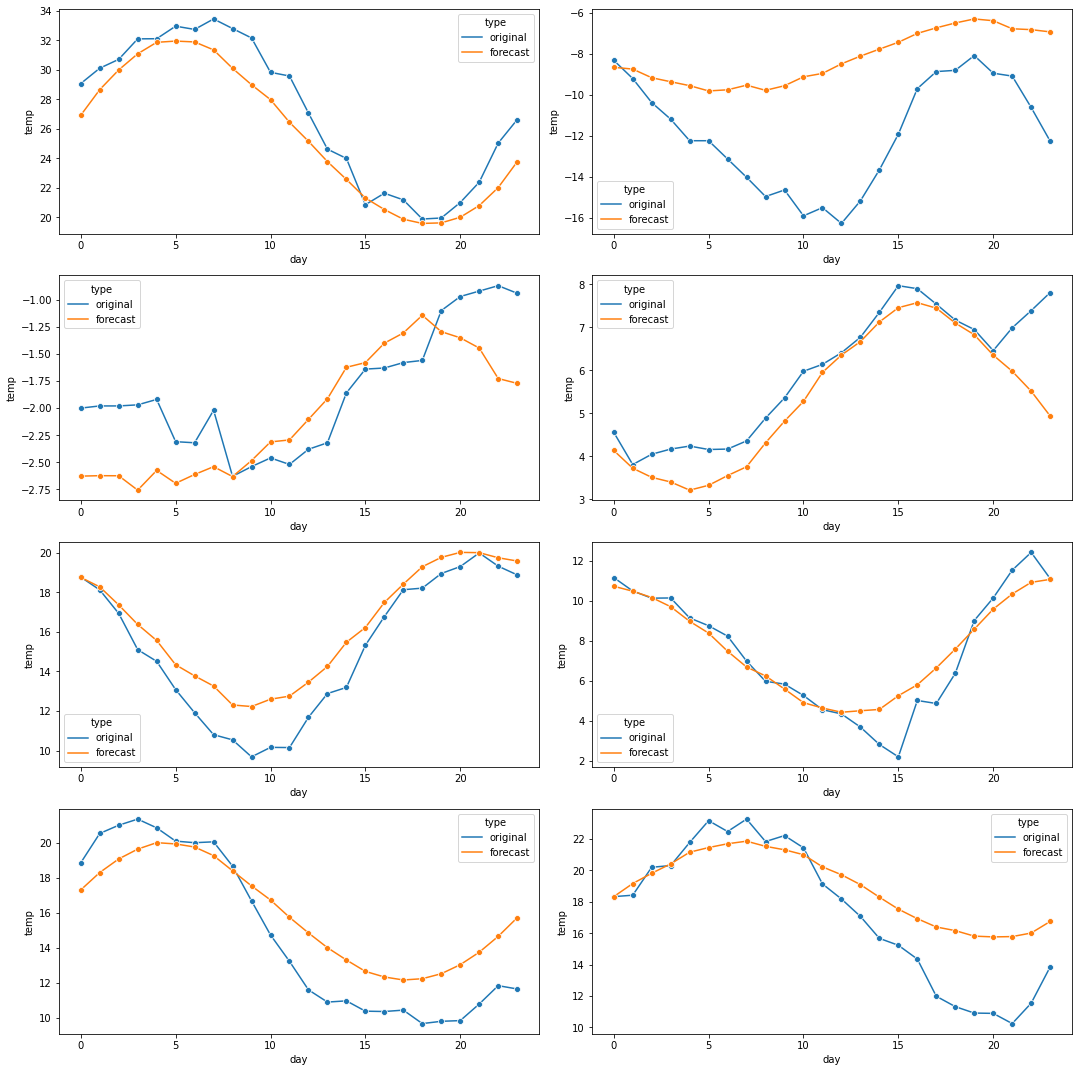

In [146]:
fig, axes = plt.subplots(
    nrows=4, 
    ncols=2, 
    figsize=(15, 15), 
    facecolor="w", 
    edgecolor="k"
)

indexes = random.sample(range(len(forecast)), 8)

for i, index in enumerate(indexes):
    
    yhat = forecast[index]
    y = Yval[index]

    frame = pd.concat([
        pd.DataFrame({'day': range(len(y)), 'temp': y, 'type': 'original'}),
        pd.DataFrame({'day': range(len(y)), 'temp': yhat, 'type': 'forecast'})
    ])
    
    frame['temp'] = [(x * train_std['temp']) + train_mean['temp'] for x in frame['temp']]
    
    sns.lineplot(x='day', y='temp', ax = axes[i // 2, i % 2], data=frame, hue='type', marker='o')
        
plt.tight_layout()

plt.show()

In [110]:
# Calculating the total average absolute error 
error = 0 
n = 0
residuals = []

for i in range(Yval.shape[0]):
    true = Yval[i]
    hat = forecast[i]
    n += len(true)
    
    true = np.asarray([(x * train_std['temp']) + train_mean['temp'] for x in true])
    hat = np.asarray([(x * train_std['temp']) + train_mean['temp'] for x in hat])
    
    residual = true - hat
    residuals.append(residual)
    
    error += np.sum([abs(x) for x in true - hat]) 

print(f'Final average absolute error: {round(error / n, 2)} C')

Final average absolute error: 1.69 C


In [111]:
# Flattening the list of arrays of residuals
residuals = np.asarray(residuals).flatten().tolist()
abs_residuals = [abs(x) for x in residuals]

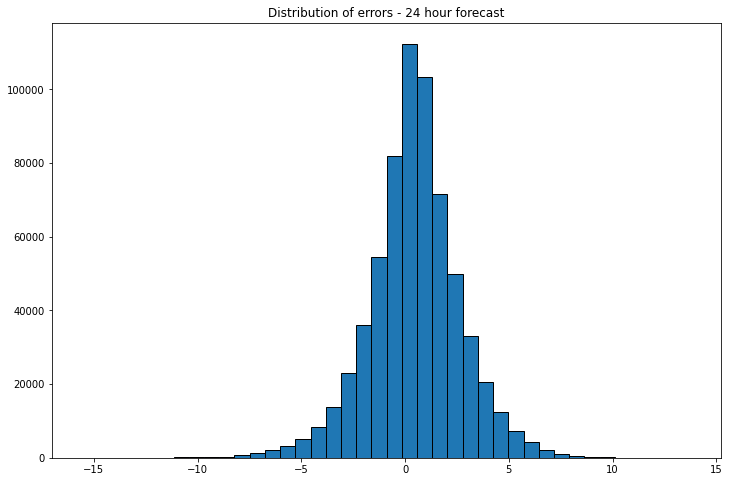

In [112]:
plt.figure(figsize=(12, 8))
plt.hist(residuals, bins=40, edgecolor='black')
plt.title('Distribution of errors - 24 hour forecast')
plt.show()

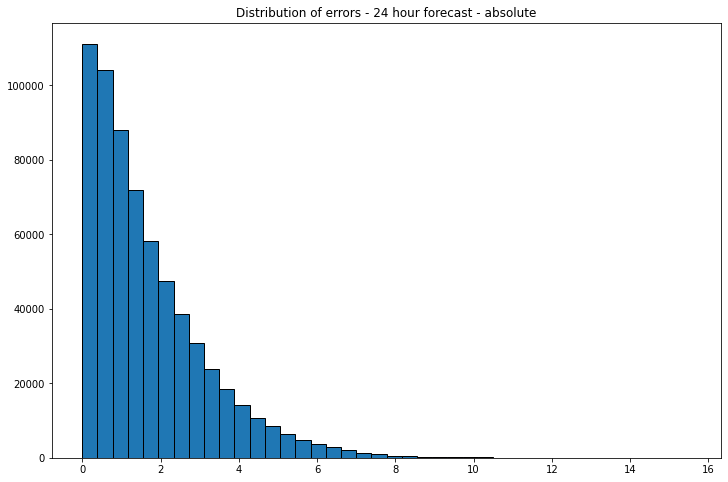

In [113]:
plt.figure(figsize=(12, 8))
plt.hist(abs_residuals, bins=40, edgecolor='black')
plt.title('Distribution of errors - 24 hour forecast - absolute')
plt.show()

In [114]:
print(f"Median absoulte error: {round(np.median(abs_residuals), 2)} C")

Median absoulte error: 1.27 C
